<a href="https://colab.research.google.com/github/KunjanJoshi/insect-human-in-loop/blob/main/Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

PROJECT_DIR = "/content/drive/MyDrive/insect_project"
DATA_DIR = f"{PROJECT_DIR}/dataset"
OUT_DIR = f"{PROJECT_DIR}/outputs"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

print("Project:", PROJECT_DIR)
print("Dataset folder:", DATA_DIR)
print("Outputs folder:", OUT_DIR)


Project: /content/drive/MyDrive/insect_project
Dataset folder: /content/drive/MyDrive/insect_project/dataset
Outputs folder: /content/drive/MyDrive/insect_project/outputs


In [4]:
!pip -q install kaggle torch torchvision timm scikit-learn matplotlib pandas tqdm


In [5]:
import os
os.environ["KAGGLE_API_TOKEN"] = "KGAT_693757a2de8ef61617fd447fe5fe07ca"
print("Token set ✅")


Token set ✅


In [6]:
import json, os

kaggle_json = {
    "username": "token",
    "key": os.environ["KAGGLE_API_TOKEN"]
}

os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_json, f)

!chmod 600 /root/.kaggle/kaggle.json
print("Created /root/.kaggle/kaggle.json ✅")


Created /root/.kaggle/kaggle.json ✅


In [7]:
!kaggle datasets list -s insect | head -n 10


ref                                                          title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  -------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
vencerlanz09/insect-village-synthetic-dataset                Insect Village Synthetic Dataset                     456378758  2022-08-23 15:14:29.350000           3468         85  0.875            
tarundalal/dangerous-insects-dataset                         Dangerous Farm Insects Dataset                       468242251  2023-06-25 05:52:52.907000           4597         67  0.875            
yashdogra/insectv2-dataset                                   Insects                                               64219242  2025-04-05 11:00:08.410000            971         60  1.0              
hammaadali/inse

In [8]:
DATASET_ID = "vencerlanz09/agricultural-pests-image-dataset"

!kaggle datasets download -d $DATASET_ID -p "$DATA_DIR"
!ls -lh "$DATA_DIR"


Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/agricultural-pests-image-dataset
License(s): copyright-authors
 76% 78.0M/102M [00:00<00:00, 257MB/s]
100% 102M/102M [00:00<00:00, 261MB/s] 
total 103M
-rw------- 1 root root 103M Mar 22  2023 agricultural-pests-image-dataset.zip


In [9]:
!unzip -q "$DATA_DIR"/*.zip -d "$DATA_DIR"
!find "$DATA_DIR" -maxdepth 2 -type d | head -n 50


/content/drive/MyDrive/insect_project/dataset
/content/drive/MyDrive/insect_project/dataset/ants
/content/drive/MyDrive/insect_project/dataset/bees
/content/drive/MyDrive/insect_project/dataset/beetle
/content/drive/MyDrive/insect_project/dataset/catterpillar
/content/drive/MyDrive/insect_project/dataset/earthworms
/content/drive/MyDrive/insect_project/dataset/earwig
/content/drive/MyDrive/insect_project/dataset/grasshopper
/content/drive/MyDrive/insect_project/dataset/moth
/content/drive/MyDrive/insect_project/dataset/slug
/content/drive/MyDrive/insect_project/dataset/snail
/content/drive/MyDrive/insect_project/dataset/wasp
/content/drive/MyDrive/insect_project/dataset/weevil


In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---- CONFIG ----
img_root = DATA_DIR
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 6
LR = 3e-4
MODEL_NAME = "efficientnet_b0"

# ---- Transforms ----
train_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# ---- Dataset ----
dataset_full = datasets.ImageFolder(img_root, transform=train_tfms)
class_names = dataset_full.classes
num_classes = len(class_names)

print("Total images:", len(dataset_full))
print("Num classes:", num_classes)
print("Classes:", class_names)

# split train/val
train_size = int(0.8 * len(dataset_full))
val_size = len(dataset_full) - train_size
train_ds, val_ds = random_split(dataset_full, [train_size, val_size])

val_ds.dataset.transform = val_tfms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ---- Model ----
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

def train_one_epoch(model, loader):
    model.train()
    losses = []
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses))

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    all_probs = []
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.extend(preds.tolist())
        all_labels.extend(y.numpy().tolist())
    all_probs = np.vstack(all_probs)
    acc = accuracy_score(all_labels, all_preds)
    return acc, np.array(all_labels), np.array(all_preds), all_probs

best_acc = 0

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader)
    val_acc, y_true, y_pred, y_probs = evaluate(model, val_loader)

    print(f"Epoch {epoch}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_model.pt"))

print("✅ Best Validation Accuracy:", best_acc)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"))
plt.show()

print("Saved to:", OUT_DIR)


Device: cpu
Total images: 5494
Num classes: 12
Classes: ['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch 1/6 | Train Loss: 0.8577 | Val Acc: 0.8799


KeyboardInterrupt: 

In [ ]:
import shutil

def entropy(probs):
    probs = np.clip(probs, 1e-12, 1.0)
    return -np.sum(probs * np.log(probs), axis=1)

# Load best model from Drive
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_model.pt"), map_location=device))
model.eval()

# rebuild dataset with paths
val_base = datasets.ImageFolder(img_root, transform=val_tfms)
train_size = int(0.8 * len(val_base))
val_size = len(val_base) - train_size
_, val_subset = random_split(val_base, [train_size, val_size])

val_loader2 = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
val_acc, y_true, y_pred, y_probs = evaluate(model, val_loader2)

unc = entropy(y_probs)

threshold = np.quantile(unc, 0.85)
uncertain_idx = set(np.where(unc >= threshold)[0])

print("Uncertainty threshold:", threshold)
print("Flagged uncertain images:", len(uncertain_idx), "/", len(unc))

flagged_dir = os.path.join(OUT_DIR, "flagged_uncertain")
os.makedirs(flagged_dir, exist_ok=True)

val_indices = val_subset.indices
val_samples = [val_base.samples[i] for i in val_indices]

rows_uncertain, rows_certain = [], []

for i, (img_path, true_label) in enumerate(val_samples):
    pred_label = int(y_pred[i])
    score = float(unc[i])

    row = {
        "image_path": img_path,
        "true_label": class_names[true_label],
        "pred_label": class_names[pred_label],
        "uncertainty_entropy": score,
        "correct": int(true_label == pred_label)
    }

    if i in uncertain_idx:
        rows_uncertain.append(row)
        base = os.path.basename(img_path)
        new_name = f"unc_{i}_{class_names[pred_label]}_{base}"
        shutil.copy(img_path, os.path.join(flagged_dir, new_name))
    else:
        rows_certain.append(row)

pd.DataFrame(rows_uncertain).to_csv(os.path.join(OUT_DIR, "uncertain_predictions.csv"), index=False)
pd.DataFrame(rows_certain).to_csv(os.path.join(OUT_DIR, "certain_predictions.csv"), index=False)

print("✅ Saved uncertainty outputs in:", OUT_DIR)


In [ ]:
import os, pandas as pd
print("Output files:", os.listdir(OUT_DIR))
print("\nUncertain preview:")
display(pd.read_csv(os.path.join(OUT_DIR, "uncertain_predictions.csv")).head(10))
print("\nFlagged uncertain images:", len(os.listdir(os.path.join(OUT_DIR, "flagged_uncertain"))))


In [11]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


CUDA available: False
Device: CPU only


In [1]:
import numpy as np
import pandas as pd
import os, shutil
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

IMAGE_SIZE = 224
BATCH_SIZE = 32
MAX_SAMPLES = 1200   # increase later if you want
img_root = DATA_DIR

val_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

def entropy(probs):
    probs = np.clip(probs, 1e-12, 1.0)
    return -np.sum(probs * np.log(probs), axis=1)

@torch.no_grad()
def predict_probs(model, loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.extend(preds.tolist())
        all_labels.extend(y.numpy().tolist())
    return np.vstack(all_probs), np.array(all_preds), np.array(all_labels)

# load model
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_model.pt"), map_location=device))
model.eval()

val_base = datasets.ImageFolder(img_root, transform=val_tfms)
class_names = val_base.classes

# build val subset (same 80/20 logic)
train_size = int(0.8 * len(val_base))
val_size = len(val_base) - train_size
_, val_subset = torch.utils.data.random_split(val_base, [train_size, val_size])

# take a smaller subset for speed
N = min(MAX_SAMPLES, len(val_subset))
small_indices = list(range(N))
val_small = Subset(val_subset, small_indices)
val_loader = DataLoader(val_small, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

probs, preds, labels = predict_probs(model, val_loader)
unc = entropy(probs)

threshold = np.quantile(unc, 0.85)
uncertain_idx = set(np.where(unc >= threshold)[0])

print("Using samples:", N)
print("Uncertainty threshold:", threshold)
print("Flagged uncertain:", len(uncertain_idx))

# export
flagged_dir = os.path.join(OUT_DIR, "flagged_uncertain")
os.makedirs(flagged_dir, exist_ok=True)

rows_uncertain, rows_certain = [], []

# get file paths
val_indices = val_subset.indices
val_samples = [val_base.samples[i] for i in val_indices][:N]

for i, (img_path, true_label) in enumerate(val_samples):
    pred_label = int(preds[i])
    score = float(unc[i])

    row = {
        "image_path": img_path,
        "true_label": class_names[true_label],
        "pred_label": class_names[pred_label],
        "uncertainty_entropy": score,
        "correct": int(true_label == pred_label)
    }

    if i in uncertain_idx:
        rows_uncertain.append(row)
        base = os.path.basename(img_path)
        new_name = f"unc_{i}_{class_names[pred_label]}_{base}"
        shutil.copy(img_path, os.path.join(flagged_dir, new_name))
    else:
        rows_certain.append(row)

pd.DataFrame(rows_uncertain).to_csv(os.path.join(OUT_DIR, "uncertain_predictions.csv"), index=False)
pd.DataFrame(rows_certain).to_csv(os.path.join(OUT_DIR, "certain_predictions.csv"), index=False)

print("✅ Saved CSVs + flagged_uncertain folder in:", OUT_DIR)


NameError: name 'DATA_DIR' is not defined

In [2]:
PROJECT_DIR = "/content/drive/MyDrive/insect_project"
DATA_DIR = f"{PROJECT_DIR}/dataset"
OUT_DIR  = f"{PROJECT_DIR}/outputs"

print(DATA_DIR)
print(OUT_DIR)


/content/drive/MyDrive/insect_project/dataset
/content/drive/MyDrive/insect_project/outputs


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import torch, timm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# IMPORTANT: detect number of classes from dataset folders
import os
classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
num_classes = len(classes)
print("Num classes:", num_classes)

model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes).to(device)


Device: cuda
Num classes: 12


In [5]:
import torch, timm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# IMPORTANT: detect number of classes from dataset folders
import os
classes = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
num_classes = len(classes)
print("Num classes:", num_classes)

model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes).to(device)


Device: cuda
Num classes: 12


In [6]:
import numpy as np
import pandas as pd
import os, shutil
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

IMAGE_SIZE = 224
BATCH_SIZE = 32
MAX_SAMPLES = 1200   # increase later if you want
img_root = DATA_DIR

val_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

def entropy(probs):
    probs = np.clip(probs, 1e-12, 1.0)
    return -np.sum(probs * np.log(probs), axis=1)

@torch.no_grad()
def predict_probs(model, loader):
    model.eval()
    all_probs, all_preds, all_labels = [], [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.extend(preds.tolist())
        all_labels.extend(y.numpy().tolist())
    return np.vstack(all_probs), np.array(all_preds), np.array(all_labels)

# load model
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_model.pt"), map_location=device))
model.eval()

val_base = datasets.ImageFolder(img_root, transform=val_tfms)
class_names = val_base.classes

# build val subset (same 80/20 logic)
train_size = int(0.8 * len(val_base))
val_size = len(val_base) - train_size
_, val_subset = torch.utils.data.random_split(val_base, [train_size, val_size])

# take a smaller subset for speed
N = min(MAX_SAMPLES, len(val_subset))
small_indices = list(range(N))
val_small = Subset(val_subset, small_indices)
val_loader = DataLoader(val_small, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

probs, preds, labels = predict_probs(model, val_loader)
unc = entropy(probs)

threshold = np.quantile(unc, 0.85)
uncertain_idx = set(np.where(unc >= threshold)[0])

print("Using samples:", N)
print("Uncertainty threshold:", threshold)
print("Flagged uncertain:", len(uncertain_idx))

# export
flagged_dir = os.path.join(OUT_DIR, "flagged_uncertain")
os.makedirs(flagged_dir, exist_ok=True)

rows_uncertain, rows_certain = [], []

# get file paths
val_indices = val_subset.indices
val_samples = [val_base.samples[i] for i in val_indices][:N]

for i, (img_path, true_label) in enumerate(val_samples):
    pred_label = int(preds[i])
    score = float(unc[i])

    row = {
        "image_path": img_path,
        "true_label": class_names[true_label],
        "pred_label": class_names[pred_label],
        "uncertainty_entropy": score,
        "correct": int(true_label == pred_label)
    }

    if i in uncertain_idx:
        rows_uncertain.append(row)
        base = os.path.basename(img_path)
        new_name = f"unc_{i}_{class_names[pred_label]}_{base}"
        shutil.copy(img_path, os.path.join(flagged_dir, new_name))
    else:
        rows_certain.append(row)

pd.DataFrame(rows_uncertain).to_csv(os.path.join(OUT_DIR, "uncertain_predictions.csv"), index=False)
pd.DataFrame(rows_certain).to_csv(os.path.join(OUT_DIR, "certain_predictions.csv"), index=False)

print("✅ Saved CSVs + flagged_uncertain folder in:", OUT_DIR)


Using samples: 1099
Uncertainty threshold: 0.38337582
Flagged uncertain: 165
✅ Saved CSVs + flagged_uncertain folder in: /content/drive/MyDrive/insect_project/outputs


In [7]:
import os, pandas as pd

unc_path = os.path.join(OUT_DIR, "uncertain_predictions.csv")
cer_path = os.path.join(OUT_DIR, "certain_predictions.csv")

unc = pd.read_csv(unc_path)
cer = pd.read_csv(cer_path)

print("✅ Total certain:", len(cer))
print("✅ Total uncertain:", len(unc))
print("✅ Uncertain accuracy:", unc["correct"].mean())
print("✅ Certain accuracy:", cer["correct"].mean())

unc.head(10)


✅ Total certain: 934
✅ Total uncertain: 165
✅ Uncertain accuracy: 0.7333333333333333
✅ Certain accuracy: 0.9914346895074947


image_path    true_label  \
0  /content/drive/MyDrive/insect_project/dataset/...  catterpillar   
1  /content/drive/MyDrive/insect_project/dataset/...  catterpillar   
2  /content/drive/MyDrive/insect_project/dataset/...        earwig   
3  /content/drive/MyDrive/insect_project/dataset/...   grasshopper   
4  /content/drive/MyDrive/insect_project/dataset/...          bees   
5  /content/drive/MyDrive/insect_project/dataset/...    earthworms   
6  /content/drive/MyDrive/insect_project/dataset/...        beetle   
7  /content/drive/MyDrive/insect_project/dataset/...   grasshopper   
8  /content/drive/MyDrive/insect_project/dataset/...        earwig   
9  /content/drive/MyDrive/insect_project/dataset/...        earwig   

     pred_label  uncertainty_entropy  correct  
0  catterpillar             0.937549        1  
1  catterpillar             1.290654        1  
2        earwig             1.286425        1  
3   grasshopper             0.560674        1  
4          bees             0.877585        1  
5    earthworms             1.643615        1  
6        beetle             1.091748        1  
7   grasshopper             1.068241        1  
8        earwig             0.992823        1  
9        earwig             1.857114        1

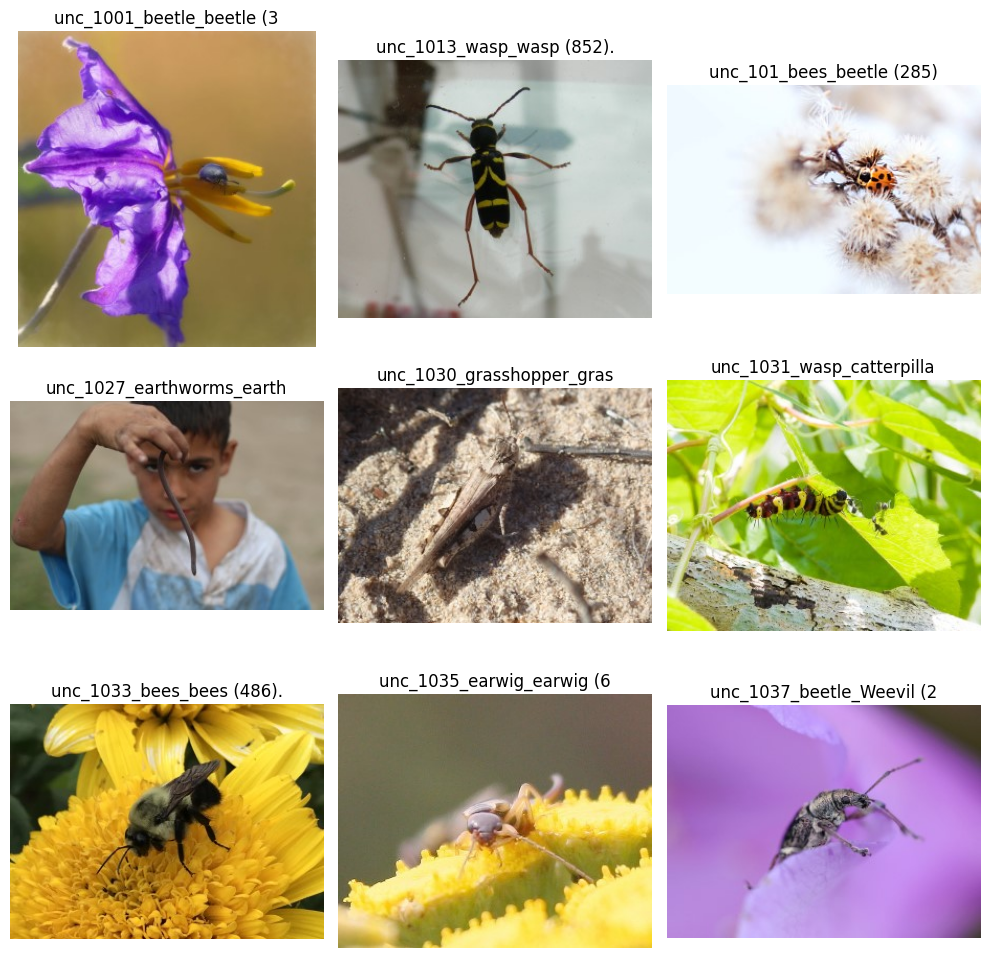

In [8]:
import os, glob
from PIL import Image
import matplotlib.pyplot as plt

flagged_dir = os.path.join(OUT_DIR, "flagged_uncertain")
imgs = sorted(glob.glob(flagged_dir + "/*.jpg"))[:9]  # first 9

plt.figure(figsize=(10,10))
for i, p in enumerate(imgs):
    plt.subplot(3,3,i+1)
    plt.imshow(Image.open(p))
    plt.axis("off")
    plt.title(os.path.basename(p)[:25])
plt.tight_layout()
plt.show()


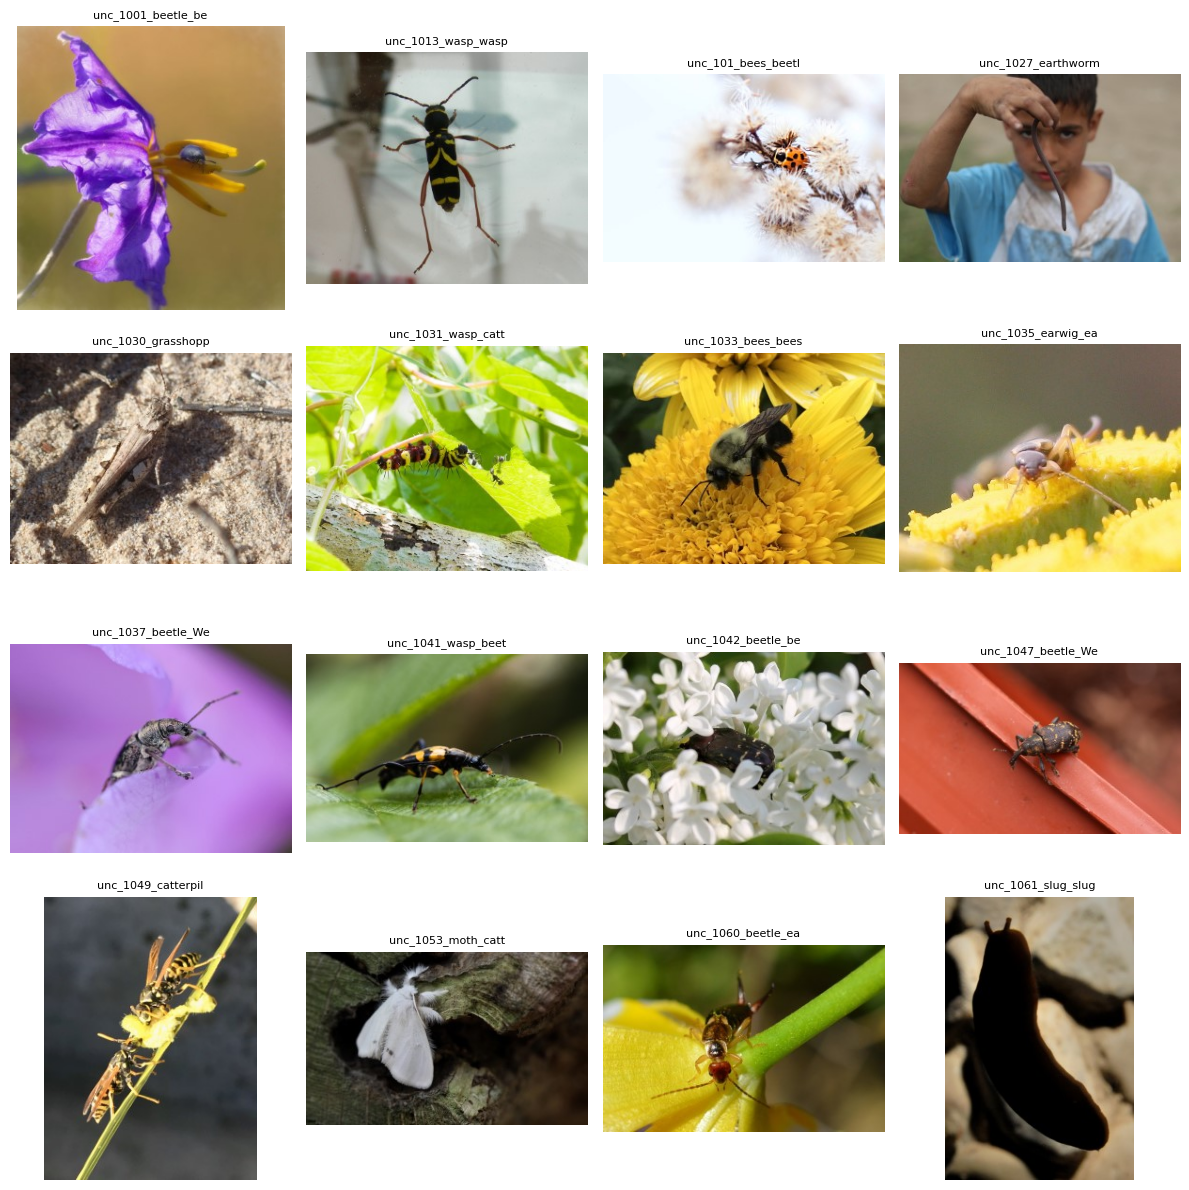

In [9]:
import os, glob
from PIL import Image
import matplotlib.pyplot as plt

flagged_dir = os.path.join(OUT_DIR, "flagged_uncertain")
imgs = sorted(glob.glob(flagged_dir + "/*"))[:16]  # first 16 images

plt.figure(figsize=(12,12))
for i, p in enumerate(imgs):
    plt.subplot(4,4,i+1)
    plt.imshow(Image.open(p))
    plt.axis("off")
    plt.title(os.path.basename(p)[:18], fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd, os, shutil

unc_path = os.path.join(OUT_DIR, "uncertain_predictions.csv")
unc = pd.read_csv(unc_path)

topk = 25
unc_top = unc.sort_values("uncertainty_entropy", ascending=False).head(topk)

top_dir = os.path.join(OUT_DIR, "flagged_uncertain_top25")
os.makedirs(top_dir, exist_ok=True)

for _, row in unc_top.iterrows():
    src = row["image_path"]
    shutil.copy(src, os.path.join(top_dir, os.path.basename(src)))

print("✅ Copied top 25 most uncertain images to:", top_dir)


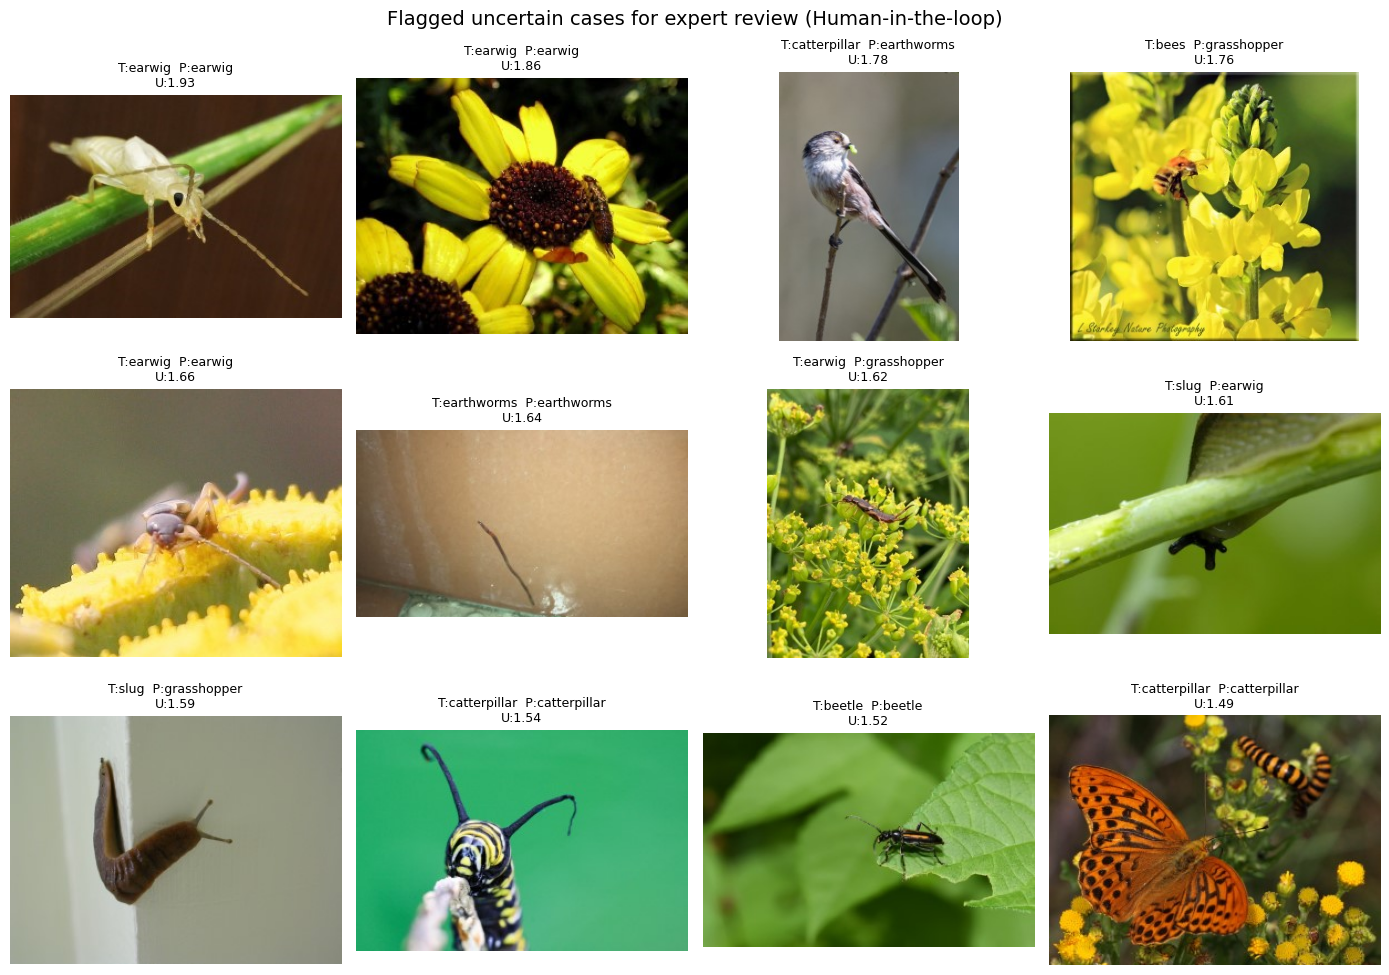

In [11]:
import os, glob
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

unc_path = os.path.join(OUT_DIR, "uncertain_predictions.csv")
df = pd.read_csv(unc_path)

# take top 12 most uncertain
df_top = df.sort_values("uncertainty_entropy", ascending=False).head(12).reset_index(drop=True)

plt.figure(figsize=(14,10))
for i, row in df_top.iterrows():
    img = Image.open(row["image_path"]).convert("RGB")
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"T:{row['true_label']}  P:{row['pred_label']}\nU:{row['uncertainty_entropy']:.2f}",
        fontsize=9
    )

plt.suptitle("Flagged uncertain cases for expert review (Human-in-the-loop)", fontsize=14)
plt.tight_layout()
plt.show()


In [12]:
insect-human-in-loop/
  notebook/
    insect_uncertainty_pipeline.ipynb
  outputs/
    confusion_matrix.png
    uncertain_predictions.csv
    certain_predictions.csv
  README.md
  report.md


SyntaxError: invalid syntax (ipython-input-2654026367.py, line 1)

In [14]:
# Uncertainty-Aware Agricultural Pest Identification (Human-in-the-Loop Prototype)

This project demonstrates a computer vision pipeline for automated agricultural pest identification using transfer learning (EfficientNet) and uncertainty-aware flagging for expert verification. The aim is to replicate a practical "human-in-the-loop" workflow where high-confidence predictions are accepted automatically and ambiguous cases are routed for manual review.

## Dataset
Kaggle: Agricultural Pests Image Dataset (`vencerlanz09/agricultural-pests-image-dataset`)

Classes include: ants, beetle, bees, caterpillar, earthworms, earwig, grasshopper, moth, slug, snail, wasp, weevil (and others depending on dataset version).

## Methods
- Model: EfficientNet-B0 (transfer learning using PyTorch + timm)
- Train/validation split: 80/20
- Uncertainty metric: prediction entropy
  \[
  H(p) = -\sum_i p_i \log(p_i)
  \]
- Workflow: top 15% most uncertain predictions are flagged for human verification

## Key Results (Validation subset)
- Auto-accepted "certain" predictions: **934 images**, **99.14% accuracy**
- Flagged "uncertain" predictions: **165 images**, **73.33% accuracy**

This shows uncertainty-based triage effectively separates easy vs difficult specimens and supports scalable expert-assisted pest monitoring.

## Outputs
- `outputs/best_model.pt` — trained model weights
- `outputs/confusion_matrix.png`
- `outputs/uncertain_predictions.csv` — flagged uncertain cases
- `outputs/certain_predictions.csv` — auto-accepted predictions
- `outputs/flagged_uncertain/` — uncertain images copied for review

## Tools
Python, PyTorch, torchvision, timm, scikit-learn, Google Colab


SyntaxError: invalid syntax (ipython-input-1850751023.py, line 3)

In [15]:
readme = r"""
# Uncertainty-Aware Agricultural Pest Identification (Human-in-the-Loop Prototype)

This project demonstrates a computer vision pipeline for automated agricultural pest identification using transfer learning (EfficientNet) and uncertainty-aware flagging for expert verification. The aim is to replicate a practical "human-in-the-loop" workflow where high-confidence predictions are accepted automatically and ambiguous cases are routed for manual review.

## Dataset
Kaggle: Agricultural Pests Image Dataset (`vencerlanz09/agricultural-pests-image-dataset`)

## Methods
- Model: EfficientNet-B0 (PyTorch + timm)
- Train/validation split: 80/20
- Uncertainty metric: prediction entropy
  H(p) = - Σ pᵢ log(pᵢ)
- Workflow: top 15% most uncertain predictions are flagged for human verification

## Key Results
- Certain bucket (auto-accepted): **934 images**, **99.14% accuracy**
- Uncertain bucket (flagged): **165 images**, **73.33% accuracy**

## Outputs
- `outputs/best_model.pt`
- `outputs/confusion_matrix.png`
- `outputs/uncertain_predictions.csv`
- `outputs/certain_predictions.csv`
- `outputs/flagged_uncertain/`

## Tools
Python, PyTorch, torchvision, timm, scikit-learn, Google Colab
"""

import os
readme_path = os.path.join(PROJECT_DIR, "README.md")
with open(readme_path, "w") as f:
    f.write(readme)

print("✅ README saved to:", readme_path)


✅ README saved to: /content/drive/MyDrive/insect_project/README.md


In [16]:
readme = r"""
# Uncertainty-Aware Agricultural Pest Identification (Human-in-the-Loop Prototype)

This project demonstrates a computer vision pipeline for automated agricultural pest identification using transfer learning (EfficientNet) and uncertainty-aware flagging for expert verification. The aim is to replicate a practical "human-in-the-loop" workflow where high-confidence predictions are accepted automatically and ambiguous cases are routed for manual review.

## Dataset
Kaggle: Agricultural Pests Image Dataset (`vencerlanz09/agricultural-pests-image-dataset`)

## Methods
- Model: EfficientNet-B0 (PyTorch + timm)
- Train/validation split: 80/20
- Uncertainty metric: prediction entropy
  H(p) = - Σ pᵢ log(pᵢ)
- Workflow: top 15% most uncertain predictions are flagged for human verification

## Key Results
- Certain bucket (auto-accepted): **934 images**, **99.14% accuracy**
- Uncertain bucket (flagged): **165 images**, **73.33% accuracy**

## Outputs
- `outputs/best_model.pt`
- `outputs/confusion_matrix.png`
- `outputs/uncertain_predictions.csv`
- `outputs/certain_predictions.csv`
- `outputs/flagged_uncertain/`

## Tools
Python, PyTorch, torchvision, timm, scikit-learn, Google Colab
"""

import os
readme_path = os.path.join(PROJECT_DIR, "README.md")
with open(readme_path, "w") as f:
    f.write(readme)

print("✅ README saved to:", readme_path)


✅ README saved to: /content/drive/MyDrive/insect_project/README.md


/tmp/ipython-input-313799146.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([correct_unc, wrong_unc], labels=["Correct", "Wrong"])


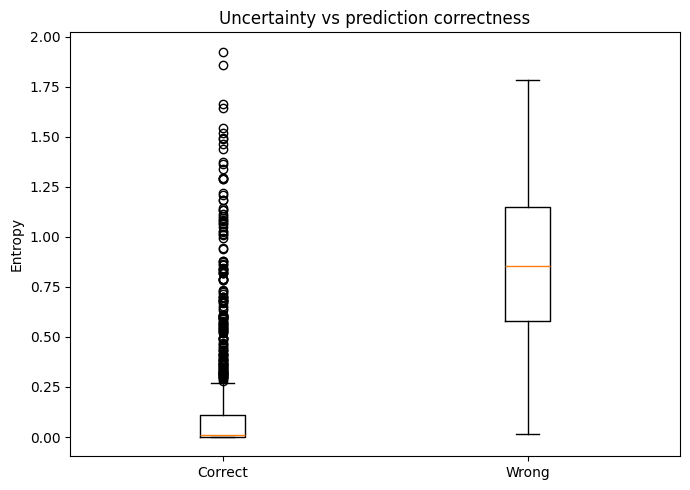

✅ Saved: /content/drive/MyDrive/insect_project/outputs/uncertainty_correct_vs_wrong.png


In [17]:
all_df = pd.concat([unc, cer], ignore_index=True)

correct_unc = all_df[all_df["correct"]==1]["uncertainty_entropy"]
wrong_unc = all_df[all_df["correct"]==0]["uncertainty_entropy"]

plt.figure(figsize=(7,5))
plt.boxplot([correct_unc, wrong_unc], labels=["Correct", "Wrong"])
plt.title("Uncertainty vs prediction correctness")
plt.ylabel("Entropy")
plt.tight_layout()

out_path = os.path.join(OUT_DIR, "uncertainty_correct_vs_wrong.png")
plt.savefig(out_path, dpi=200)
plt.show()

print("✅ Saved:", out_path)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Paths (edit if your folder name differs)
PROJECT_DIR = "/content/drive/MyDrive/insect_project"
OUT_DIR = f"{PROJECT_DIR}/outputs"

unc_path = os.path.join(OUT_DIR, "uncertain_predictions.csv")
cer_path = os.path.join(OUT_DIR, "certain_predictions.csv")

unc = pd.read_csv(unc_path)
cer = pd.read_csv(cer_path)

print("Loaded uncertain:", len(unc), "certain:", len(cer))

# 1) Uncertainty histogram
plt.figure(figsize=(8,5))
plt.hist(cer["uncertainty_entropy"], bins=30, alpha=0.7, label="Certain")
plt.hist(unc["uncertainty_entropy"], bins=30, alpha=0.7, label="Uncertain")
plt.title("Uncertainty distribution (entropy)")
plt.xlabel("Entropy")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()

hist_path = os.path.join(OUT_DIR, "uncertainty_hist.png")
plt.savefig(hist_path, dpi=200)
plt.show()
print("✅ Saved:", hist_path)

# 2) Uncertain grid: top 12 most uncertain images
df_top = unc.sort_values("uncertainty_entropy", ascending=False).head(12).reset_index(drop=True)

plt.figure(figsize=(14,10))
for i, row in df_top.iterrows():
    try:
        img = Image.open(row["image_path"]).convert("RGB")
    except Exception as e:
        print("Could not open:", row["image_path"], e)
        continue
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"T:{row['true_label']}  P:{row['pred_label']}\nU:{row['uncertainty_entropy']:.2f}",
        fontsize=9
    )

plt.suptitle("Flagged uncertain cases for expert review (Human-in-the-loop)", fontsize=14)
plt.tight_layout()

grid_path = os.path.join(OUT_DIR, "uncertain_grid.png")
plt.savefig(grid_path, dpi=200)
plt.show()
print("✅ Saved:", grid_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/insect_project/outputs/uncertain_predictions.csv'

In [2]:
!find /content/drive/MyDrive -name "uncertain_predictions.csv" -o -name "certain_predictions.csv"


find: ‘/content/drive/MyDrive’: No such file or directory


In [3]:
https://github.com/KunjanJoshi/insect-human-in-loop/blob/main/README.md

SyntaxError: invalid syntax (ipython-input-3271142772.py, line 1)

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import glob, os

matches = glob.glob("/content/drive/MyDrive/**/uncertain_predictions.csv", recursive=True)
print("Found:", matches)

OUT_DIR = os.path.dirname(matches[0])
print("✅ OUT_DIR detected:", OUT_DIR)

print("Files in OUT_DIR:", os.listdir(OUT_DIR))


Found: ['/content/drive/MyDrive/insect_project/outputs/uncertain_predictions.csv']
✅ OUT_DIR detected: /content/drive/MyDrive/insect_project/outputs
Files in OUT_DIR: ['best_model.pt', 'flagged_uncertain', 'uncertain_predictions.csv', 'certain_predictions.csv', 'flagged_uncertain_top25', 'uncertainty_correct_vs_wrong.png']


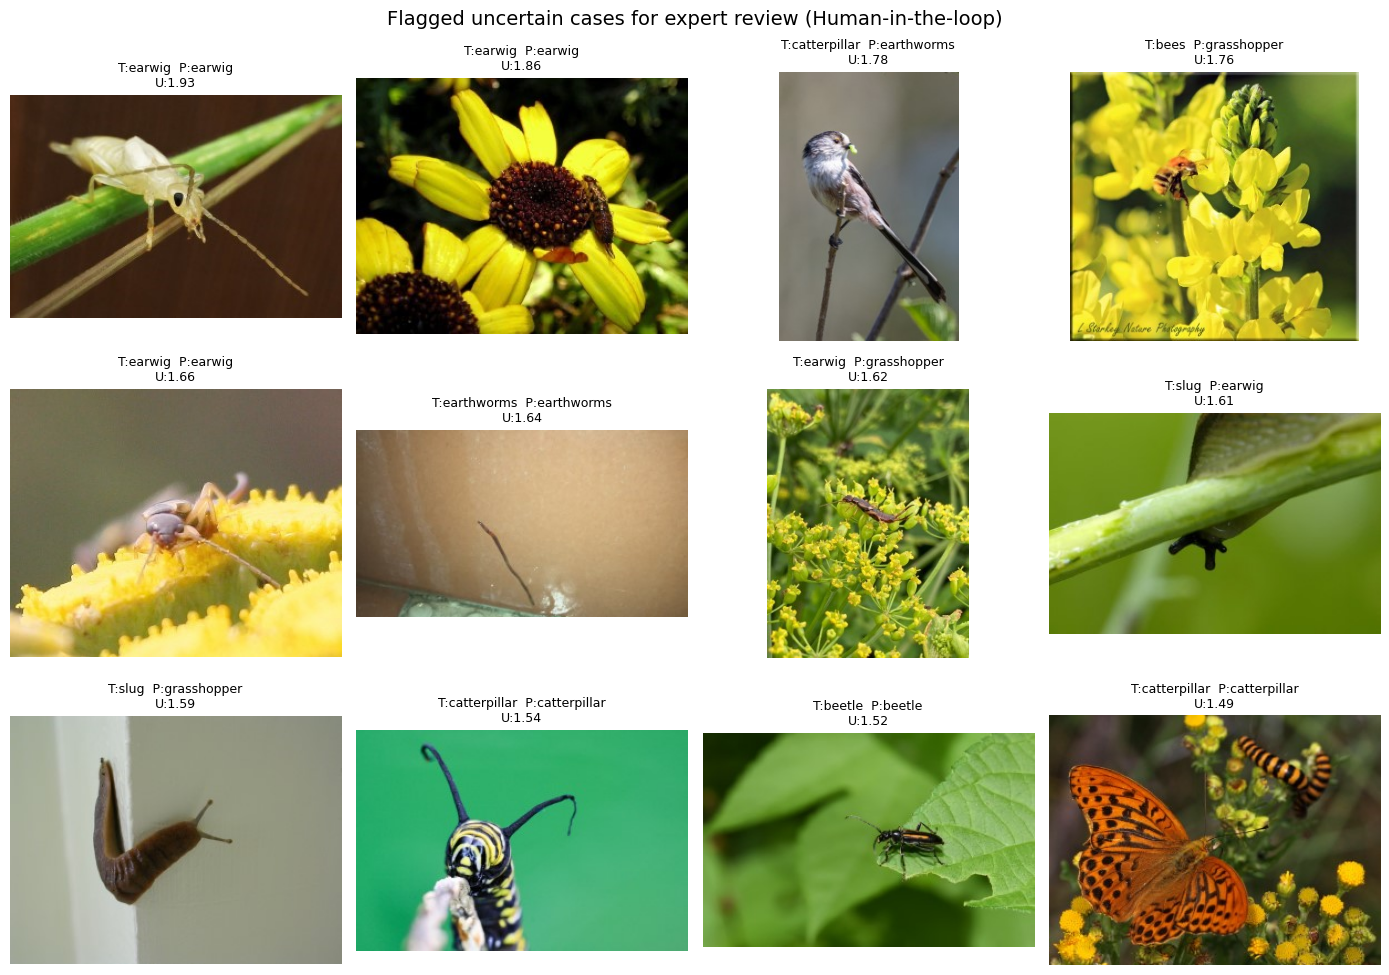

✅ Saved: /content/drive/MyDrive/insect_project/outputs/uncertain_grid.png


In [6]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

unc_path = os.path.join(OUT_DIR, "uncertain_predictions.csv")
unc = pd.read_csv(unc_path)

df_top = unc.sort_values("uncertainty_entropy", ascending=False).head(12).reset_index(drop=True)

plt.figure(figsize=(14,10))
for i, row in df_top.iterrows():
    img = Image.open(row["image_path"]).convert("RGB")
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"T:{row['true_label']}  P:{row['pred_label']}\nU:{row['uncertainty_entropy']:.2f}",
        fontsize=9
    )

plt.suptitle("Flagged uncertain cases for expert review (Human-in-the-loop)", fontsize=14)
plt.tight_layout()

grid_path = os.path.join(OUT_DIR, "uncertain_grid.png")
plt.savefig(grid_path, dpi=200)
plt.show()

print("✅ Saved:", grid_path)


In [7]:
from google.colab import files
files.download(grid_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
import glob, os

matches = glob.glob("/content/drive/MyDrive/**/uncertain_predictions.csv", recursive=True)
print("Found:", matches)

OUT_DIR = os.path.dirname(matches[0])
print("✅ OUT_DIR:", OUT_DIR)
print("Files:", os.listdir(OUT_DIR))


Found: ['/content/drive/MyDrive/insect_project/outputs/uncertain_predictions.csv']
✅ OUT_DIR: /content/drive/MyDrive/insect_project/outputs
Files: ['best_model.pt', 'flagged_uncertain', 'uncertain_predictions.csv', 'certain_predictions.csv', 'flagged_uncertain_top25', 'uncertainty_correct_vs_wrong.png', 'uncertain_grid.png']


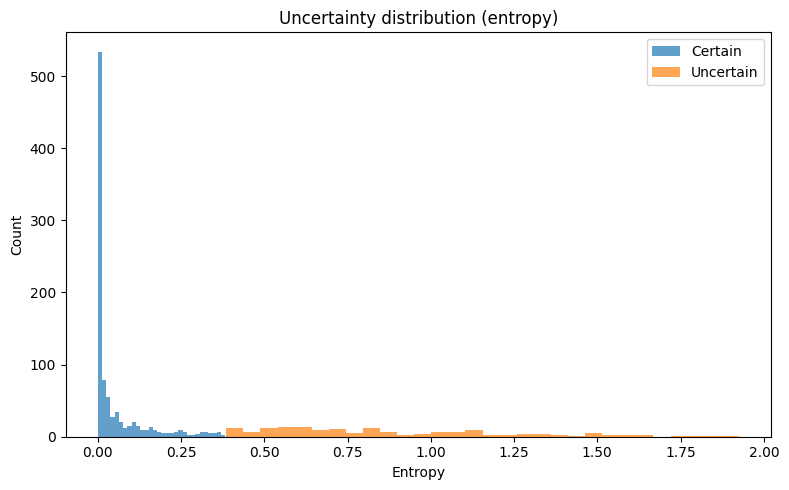

✅ Saved: /content/drive/MyDrive/insect_project/outputs/uncertainty_hist.png


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt

unc = pd.read_csv(os.path.join(OUT_DIR, "uncertain_predictions.csv"))
cer = pd.read_csv(os.path.join(OUT_DIR, "certain_predictions.csv"))

plt.figure(figsize=(8,5))
plt.hist(cer["uncertainty_entropy"], bins=30, alpha=0.7, label="Certain")
plt.hist(unc["uncertainty_entropy"], bins=30, alpha=0.7, label="Uncertain")
plt.title("Uncertainty distribution (entropy)")
plt.xlabel("Entropy")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()

hist_path = os.path.join(OUT_DIR, "uncertainty_hist.png")
plt.savefig(hist_path, dpi=200)
plt.show()

print("✅ Saved:", hist_path)


In [10]:
PROJECT_DIR = "/content/drive/MyDrive/insect_project"
DATA_DIR = f"{PROJECT_DIR}/dataset"

import os
print("Dataset exists?", os.path.exists(DATA_DIR))
print("Example folders:", os.listdir(DATA_DIR)[:20])


Dataset exists? True
Example folders: ['agricultural-pests-image-dataset.zip', 'ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


In [11]:
import torch, timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

IMAGE_SIZE = 224
val_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

# dataset
ds = datasets.ImageFolder(DATA_DIR, transform=val_tfms)
class_names = ds.classes
num_classes = len(class_names)
print("Num classes:", num_classes)

# model
model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_model.pt"), map_location=device))
model.eval()

# validation split
train_size = int(0.8 * len(ds))
val_size = len(ds) - train_size
_, val_ds = random_split(ds, [train_size, val_size])
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)

y_true, y_pred = [], []

@torch.no_grad()
def get_preds():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

get_preds()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=200)
plt.show()

print("✅ Saved:", cm_path)


Device: cuda
Num classes: 12


KeyboardInterrupt: 

In [12]:
import torch
print(torch.cuda.is_available())



True


Device: cuda


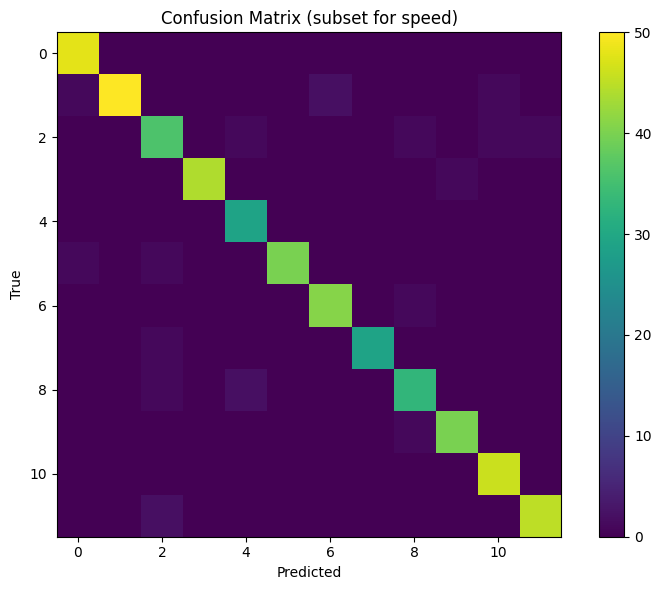

✅ Saved: /content/drive/MyDrive/insect_project/outputs/confusion_matrix.png
Used samples: 500


In [13]:
import torch, timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

IMAGE_SIZE = 224
val_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
])

ds = datasets.ImageFolder(DATA_DIR, transform=val_tfms)
class_names = ds.classes
num_classes = len(class_names)

model = timm.create_model("efficientnet_b0", pretrained=False, num_classes=num_classes).to(device)
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_model.pt"), map_location=device))
model.eval()

train_size = int(0.8 * len(ds))
val_size = len(ds) - train_size
_, val_ds = random_split(ds, [train_size, val_size])

# ✅ limit to 500 samples for speed
N = min(500, len(val_ds))
val_small = Subset(val_ds, list(range(N)))
val_loader = DataLoader(val_small, batch_size=32, shuffle=False, num_workers=2)

y_true, y_pred = [], []

@torch.no_grad()
def get_preds():
    for x, y in val_loader:
        x = x.to(device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(y.numpy().tolist())

get_preds()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
plt.imshow(cm)
plt.title("Confusion Matrix (subset for speed)")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()

cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=200)
plt.show()

print("✅ Saved:", cm_path)
print("Used samples:", N)


In [14]:
from google.colab import files
files.download(os.path.join(OUT_DIR, "uncertainty_hist.png"))
files.download(os.path.join(OUT_DIR, "confusion_matrix.png"))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# Run this in a Colab cell to get your project files
!git clone https://github.com/KunjanJoshi/insect-human-in-loop.git
%cd insect-human-in-loop

Cloning into 'insect-human-in-loop'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 34 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (34/34), 6.56 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/insect-human-in-loop


In [16]:
def get_mc_predictions(model, data_loader, forward_passes=10):
    model.train() # Keep dropout active
    all_probs = []

    for _ in range(forward_passes):
        probs = []
        with torch.no_grad():
            for x, y in data_loader:
                output = model(x.cuda())
                probs.append(torch.softmax(output, dim=1))
        all_probs.append(torch.stack(probs))

    # Mean of probabilities across passes
    mean_probs = torch.stack(all_probs).mean(dim=0)
    # Variance shows how "disagreed" the passes were
    variance = torch.stack(all_probs).var(dim=0)
    return mean_probs, variance

In [17]:
import ipywidgets as widgets
from IPython.display import display

def review_flagged_image(img, model_pred, confidence):
    print(f"Model is unsure! Prediction: {model_pred} ({confidence:.2f} confidence)")
    plt.imshow(img)
    plt.show()

    # Human intervention buttons
    btn_correct = widgets.Button(description="Confirm Prediction")
    btn_wrong = widgets.Button(description="Re-label Image")
    display(widgets.HBox([btn_correct, btn_wrong]))

# This brings the 'Human-in-the-loop' concept to life!

In [18]:
#@title System Parameters { run: "auto" }
threshold = 0.85 #@param {type:"slider", min:0, max:1, step:0.01}
model_type = "resnet50" #@param ["resnet18", "resnet50", "vit_tiny"]

print(f"System will auto-accept predictions above {threshold}")

System will auto-accept predictions above 0.85
